In [1]:
from transformers import BertForTokenClassification, BertPreTrainedModel, BertConfig, BertTokenizer, BertModel
from transformers import BertForMaskedLM, BertPreTrainedModel, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import os
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#加入CWC語料
#用誤代語料，然後產生標記檔 
news = open('1209\\newsCorpus.txt', 'r', encoding='utf-8')
err = open('1209\\對比資料庫.txt', 'r', encoding='utf-8')  
#test_err = open('1209\\test_err.txt', 'w', encoding='utf-8')
max_len = 110
err_type = []
        
test_label = []
with open('1209\\train_dataset.txt', 'w', encoding='utf-8') as train_data:
        t = {}
        e_num = 0
        while True: 
            err_line = err.readline()
            if not err_line:break
            lineTo = err_line.split(',')
            err_sen = lineTo[1].replace(' ','')
            if len(lineTo[1].replace(' ',''))<=3 and len(lineTo[0].replace(' ',''))<=3:continue
            #if err_sen.find(lineTo[11].replace(' ','')) < 0 or err_sen.count(lineTo[11].replace(' ',''))>1:continue
            if ('＆' in lineTo[1]) or ('&' in lineTo[1]) or ('+' in lineTo[1])  or ('＄' in lineTo[1]) or ('$' in lineTo[1]):continue
            if len(lineTo[0].replace(' ',''))>110:continue
            if len(lineTo)>0 : 
                if len(lineTo[9])==3:
                    if lineTo[9] in t.keys():t[lineTo[9]] += 1
                    else:t[lineTo[9]] = 1
                        
                if len(lineTo[9])==3:
                    if lineTo[9]=='MST':
                        err_sen = lineTo[1].split()
                        cor_sen = lineTo[0].split()
                        #print(err_sen, cor_sen)                        
                        
                        labels = ''
                        for i in range(len(err_sen)):
                            if cor_sen[i] != err_sen[i]:labels += '1'*len(err_sen[i])
                            else:labels += '0'*len(err_sen[i])
                        for i in range(max_len-len(lineTo[1].replace(' ',''))):
                            labels += '0'
                        
                        #train_data.write(lineTo[0].replace(' ','')+','+lineTo[1].replace(' ','')+','+labels+'\n')#寫修正句&偏誤句
                        train_data.write(lineTo[1].replace(' ','')+','+labels+','+lineTo[0].replace(' ','')+'\n')#寫誤代句
                        e_num += 1
        
        n_num = 0
        
        while True:
            labels = ''
            news_line = news.readline()
            if n_num >= 11261:break
            if not news_line:break
            for _ in range(max_len):labels += '0'
            train_data.write(news_line.replace('\n','') + ',' + labels + '\n')#寫新聞句            
            n_num += 1 
            
news.close()
err.close()
print(t, e_num, n_num)

{'OMS': 11523, 'MOD': 1995, 'MST': 11261, 'ADT': 8745, '009': 1} 11261 11261


In [2]:
e_num = 0
n_num = 0
confusion = open("1209\\字音混淆集.txt",'r',encoding='utf-8') #經過字形與字音相似度計算後，為相似字的表

dict={}
while(True):
    line = confusion.readline().strip()
    
    if line:
        line = line.split('　')
        if len(line)!=1:
            dict[line[0]] = line[1]
        
    else:
        break
confusion.close()

table = open("1209\\wordtest4.txt",'r',encoding='utf-8') #要挑的字表
s=0
dict2={}

while(True):
    line = table.readline().strip()
    
    if not line:break
    line = line.split(',')
    dict2[s] = line[0]
    s+=1
        
table.close()

import random
max_len = 110
def test_(c): #產生錯字
    if random.random() <= 0.8: #有0.8的機率是相似的錯字
        line = dict[c].split(' ')
        return line[random.randint(0,len(line)-1)]
    else:    #有0.2的機率是隨機抽字
        a = random.randint(0,len(dict2)-1)
        while(c==dict2[a]):
            a = random.randint(0,len(dict2)-1)
        return dict2[a]

file =  open("1209\\newsCorpus.txt",'r',encoding='utf-8') #要被變成訓練資料的句子，也是校正層解答
answer_list=''
a=0
file2 =  open("1209\\train_dataset.txt",'w',encoding='utf-8') #產生的訓練資料句

while True:
    
    line2=''
    answer=[]
    line = file.readline()
    if not line:break
    if e_num >= 20000: break
    for ch in ['， ', ', ', ' ,', ',']:#
        line = line.replace(ch, '，')
    line = line.replace('︵', '(')
    line = line.replace('︶', ')')
    line = line.replace(':', '：')
    if len(line)>max_len:continue
    e_num += 1
    for i in line.replace('\n', ''):
        if a==0:
            if random.randint(1,15) == 10: #有1/15的機率 把這個字當成錯字
                a+=1
                if dict.get(i) != None: #若這個字不再字表中，則選擇下一個字為錯字 會有a去計數
                    line2+=test_(i)
                    a-=1
                    answer.append(1)
                else:
                    line2+=i
                    answer.append(0)
            else:
                line2+=i
                answer.append(0)
                
        else:   #若a>0以上，則要一直挑錯字，直到a==0
            if dict.get(i) != None: #
                line2+=test_(i)
                a-=1
                answer.append(1)
            else:
                line2+=i
                answer.append(0)
                
    for j in answer:  #寫入答案
        answer_list+=str(j)
    for i in range(max_len-len(answer_list)):answer_list += '0'
    file2.write(line2 + ',' + answer_list + ',' + line.replace('\n', '') + '\n')
    answer_list=''
'''
news = open('1209\\newsCorpus.txt', 'r', encoding='utf-8')
n_num = 0
while True:
    labels = ''
    news_line = news.readline()
    if not news_line:break
    if n_num >= 1e5:break
    for _ in range(max_len):labels += '0'
    file2.write(news_line.replace('\n','') + ',' + labels + '\n')#寫新聞句 
    n_num += 1
    
news.close()
'''
file2.close()  
file.close()
print(e_num, n_num)

20000 0


In [3]:
from sklearn.model_selection import train_test_split
x, y, tar = [], [], []
with open('1209\\train_dataset.txt', 'r', encoding='utf-8') as train_data:
    while True:
        line = train_data.readline()
        if not line:break
        line = line.replace('\n', '')
        data = line.split(',')
        tmp = list(data[0])
        for i in range(len(tmp)):            
            if data[1][i] == '1':                
                tmp[i] = '[MASK]'
                data[0] = ''.join(tmp)
        x.append(data[0])
        tar.append(data[2])
        y.append([int(i) for i in data[1]])
        #y.append([int(i) for i in data[1]])


x_train, x_val, y_train, y_val, t_train, t_val =\
    train_test_split(x, y, tar, test_size=0.0075, random_state=2021)
print(x_train[:2], x_val[:2], y_train[:2], y_val[:2], t_train[:2], t_val[:2], len(x_train), len(x_val))


['[MASK]週日舉行一項類似會議後，伊拉克已開[MASK]著手恢復電力供[MASK]，修復[MASK]聯軍轟炸而[MASK]壞的橋樑與主要道路。', '據瞭解，八一一[MASK]院已取出許滿堂腰部的子彈，[MASK]研判由於傷及脊椎，[MASK][MASK]身有癱瘓的可能。'] ['尤麗雯強調，[MASK]部不好的人應避免飲用咖啡，胃腸機能好的也應儘量在[MASK]後飲用', '基於預[MASK]法[MASK]七十三[MASK]規定從未動用[MASK]，如八十年度公債數確實追加，將創下我國首次追加歲入預算先例。'] [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [4]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [5]:
MAX_LEN = max_len
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
def preprocessing_for_bert(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=False,
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

In [6]:
MAX_LEN = max_len
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
def preprocessing_for_decoder(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    
    return input_ids, attention_masks

In [7]:
train_inputs, train_masks = preprocessing_for_bert(x_train)
val_inputs, val_masks = preprocessing_for_bert(x_val)
train_target, train_tar_masks = preprocessing_for_decoder(t_train)
val_target, val_tar_masks = preprocessing_for_decoder(t_val)

#train_inputs, train_masks = preprocessing_for_bert_At(x_train)
#val_inputs, val_masks = preprocessing_for_bert_At(x_val)
print(train_inputs[:2], train_target[:2])

text = tokenizer.decode(train_inputs[0])

tokens = tokenizer.tokenize(text)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\islab\Anaconda3\envs\pytorch\lib\site-packages\transformers-4.1.1-py3.8.egg\transformers\tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


tensor([[ 103, 6867, 3189, 5647, 6121,  671, 7517, 7546,  849, 3298, 6359, 2527,
         8024,  823, 2861, 1046, 2347, 7274,  103, 5865, 2797, 2612, 2541, 7442,
         1213,  897,  103, 8024,  934, 2541,  103, 5474, 6725, 6755, 4156, 5445,
          103, 1889, 4638, 3578, 3558, 5645,  712, 6206, 6887, 6662,  511,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [3087, 4747, 6237, 8024, 1061,  671,  671,  103, 7368, 2347, 1357, 1139,
         6258, 4021, 1828, 5587, 6956, 4638, 2094, 2492, 8024,  103, 4777, 1161,
         4507, 3176, 1003, 1350, 5550, 3491, 8024,  103,  103, 6716, 3300, 4629,
      

In [23]:
tmp_data = TensorDataset(train_inputs, train_target, train_masks, train_tar_masks)
tmp_sampler = RandomSampler(tmp_data)
tmp_dataloader = DataLoader(tmp_data, sampler=tmp_sampler, batch_size=32)
tmp_iter = iter(tmp_dataloader)
tmp_inputs, tmp_target, tmp_src_masks, tmp_tar_masks = next(tmp_iter)
tmp_inputs, tmp_target, tmp_src_masks, tmp_tar_masks

(tensor([[ 800, 6134, 4850,  ...,    0,    0,    0],
         [1139, 6631, 3175,  ...,    0,    0,    0],
         [1347, 1217, 6857,  ...,    0,    0,    0],
         ...,
         [ 800, 6303, 8024,  ...,    0,    0,    0],
         [ 103, 3087, 4472,  ...,    0,    0,    0],
         [6857,  855, 5836,  ...,    0,    0,    0]]),
 tensor([[ 101,  800, 6134,  ...,    0,    0,    0],
         [ 101, 1139, 6631,  ...,    0,    0,    0],
         [ 101, 1347, 1217,  ...,    0,    0,    0],
         ...,
         [ 101,  800, 6303,  ...,    0,    0,    0],
         [ 101, 3418, 3087,  ...,    0,    0,    0],
         [ 101, 6857,  855,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
 

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=110):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        out = (x - mean) / (std + self.eps)
        out = self.gamma * out + self.beta
        return out

In [10]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Transformer, TransformerDecoder, TransformerDecoderLayer

class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        BERT_MODEL_NAME = 'bert-base-chinese'
        self.model_type = 'BertEncoderTransformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.bertEncoder = BertModel.from_pretrained(BERT_MODEL_NAME)
        self.norm = LayerNorm(ninp)
        decoder_layers = TransformerDecoderLayer(d_model=ninp, nhead=nhead)
        self.tf_decoder = TransformerDecoder(decoder_layers, num_layers=nlayers, norm=self.norm)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.final_layer = nn.Linear(ninp, ntoken)
        self.ninp = ninp
        self.init_weights()
    
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
    
    def make_src_mask(self, src):
        src_pad_mask = (src == 0)
        src_pad_mask[src_pad_mask == True] = float('-inf') 
        #return src_pad_mask
        return src_pad_mask.to(device)
        
    def make_tar_mask(self, tar): 
        tar_pad_mask = (tar == 0)
        tar_pad_mask[tar_pad_mask == True] = float('-inf')        
        tar_len = tar.size(1)
        tar_sub_mask = self.generate_square_subsequent_mask(sz=tar_len)
        #return tar_pad_mask, tar_sub_mask
        return tar_pad_mask.to(device), tar_sub_mask.to(device) 
    
    def forward(self, input_ids, target_ids, masks): 
        inp_pad_mask = self.make_src_mask(input_ids)
        tar_pad_mask, tar_mask = self.make_tar_mask(target_ids)
        tar = self.encoder(target_ids) * math.sqrt(self.ninp)
        tar = self.pos_encoder(tar)
        enc_src = self.bertEncoder(input_ids=input_ids, attention_mask=masks)
        #print(enc_src[0].permute(1, 0, 2), tar.permute(1, 0, 2))
        output = self.tf_decoder(tar.permute(1, 0, 2), enc_src[0].permute(1, 0, 2), tar_mask, None, tar_pad_mask, inp_pad_mask)#
        output = self.final_layer(output.permute(1, 0, 2))
        return output

In [84]:
tfModel = TransformerModel(len(tokenizer.vocab), 768, 4, 256, 3)
logits = tfModel(tmp_inputs, tmp_target, tmp_src_masks)
print(logits)
logits.size()

tensor([[[-0.2523, -0.4949, -0.0787,  ..., -0.2339,  0.0025,  0.7895],
         [ 0.0633, -0.1229, -0.2995,  ...,  0.1776,  0.1418,  1.0522],
         [ 0.5302, -0.6611,  0.4081,  ...,  0.3003,  0.3800,  1.0580],
         ...,
         [-0.4324,  0.2048,  0.8726,  ..., -0.3694, -0.3006, -0.1689],
         [-0.2718,  0.3926,  0.4407,  ..., -0.9153, -0.3798,  0.0645],
         [ 0.0169,  0.0217,  0.6242,  ..., -0.8467, -0.1707,  0.1095]],

        [[ 0.0656, -0.8437, -0.5346,  ...,  0.0076,  0.7674,  1.3848],
         [ 0.5429, -0.5795, -0.0129,  ..., -0.1516,  0.8903,  1.5826],
         [ 0.4190,  0.3253, -0.1198,  ...,  0.0723,  0.3485,  1.0577],
         ...,
         [ 0.2071,  0.3805,  0.5485,  ..., -0.4291,  0.0979,  0.2554],
         [ 0.1132,  0.3641,  0.0091,  ...,  0.0449,  0.2059,  0.8035],
         [ 0.5923,  0.0371,  0.5863,  ..., -0.5191,  0.1637,  0.8203]],

        [[-0.0366, -0.8048, -0.3428,  ...,  0.7820,  0.3735,  0.9353],
         [-0.3418,  0.0357, -0.3500,  ...,  0

torch.Size([32, 110, 21128])

In [11]:
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_target, train_masks, train_tar_masks)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_target, val_masks, val_tar_masks)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
train_data[:1], tokenizer.decode(train_data[:1][0][0]), val_data[:1], tokenizer.decode(val_data[:1][0][0]), len(val_data)

((tensor([[ 103, 6867, 3189, 5647, 6121,  671, 7517, 7546,  849, 3298, 6359, 2527,
           8024,  823, 2861, 1046, 2347, 7274,  103, 5865, 2797, 2612, 2541, 7442,
           1213,  897,  103, 8024,  934, 2541,  103, 5474, 6725, 6755, 4156, 5445,
            103, 1889, 4638, 3578, 3558, 5645,  712, 6206, 6887, 6662,  511,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
              0,    0]]),
  tensor([[ 101,  677, 6867, 3189, 5647, 6121,  671, 7517, 7546,  849, 3298, 6359,
           2527, 8024,  823, 2861, 1046, 2347, 7274, 1993, 5865, 2797, 2612, 2541,
           7442, 1213,  897, 2746, 8024,  934, 2541, 6158, 54

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [171]:
import numpy as np
import pandas as pd
import random
maskedLM_model = maskedLM_model.to(device)
def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    loss = nn.CrossEntropyLoss()
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_target_ids, b_masks = tuple(t.to(device) for t in batch)
        
        for b_input_id, b_label, b_target_id, b_mask in zip(b_input_ids, b_labels, b_target_ids, b_masks):
            
            masked_index = torch.nonzero(b_label).cpu().numpy()[:,0]
            if len(masked_index) == 0:continue
            # Compute logits
            with torch.no_grad():
                logits = maskedLM_model(input_ids = torch.unsqueeze(b_input_id, 0), attention_mask = torch.unsqueeze(b_mask, 0), labels=torch.unsqueeze(b_target_id, 0) )   
            # Compute loss
            #losses = logits[0]
            m_logits = logits[1].cpu().numpy()
            mask_logits = torch.tensor([m_logits[0][i] for i in masked_index])
            real_ids = torch.tensor([b_target_id.cpu().numpy()[i] for i in masked_index])
            pred_ids = torch.max(mask_logits, 1)[1].data
            if torch.equal(real_ids, pred_ids):cor_count += 1
            '''
            ## print the result
            print(torch.max(mask_logits, 1)[1].data, real_ids)
            print(loss(mask_logits, real_ids), losses)
            #loss(mask_logits, real_ids)
            text = tokenizer.decode(b_input_id)
            tokens = tokenizer.tokenize(text)

            print("輸入 tokens ：", tokens[:])
            print('-' * 50)
            for mask_id in masked_index:
                probs, indices = torch.topk(torch.softmax(logits[1][0][mask_id], -1), 1)
                predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())
                for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
                    tokens[mask_id] = t
            print("{}".format(tokens[:]))
            '''
        # Get the predictions    
        #pred = torch.max(logits[1], 1)[1].data
        #print(loss, pred)
        #y_pred_s += list(pred.cpu().numpy())          
        #y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    #df = pd.DataFrame(data)
    del maskedLM_model
    return cor_count

# Compute the average accuracy and loss over the validation set.

#y_real_s, y_pred_s = get_test_result(val_dataloader)
get_test_result(train_dataloader)
#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


474

In [13]:
class configurations(object):
    def __init__(self):
        self.batch_size = 16
        self.emb_dim = 768
        self.hid_dim = 512
        self.n_layers = 4
        self.ntokens = len(tokenizer.vocab)
        self.dropout = 0.5
        self.n_head = 8
config = configurations()

In [32]:
tmpModel = TransformerModel(config.ntokens, config.emb_dim, config.n_head, config.hid_dim, config.n_layers)
logits = tmpModel(tmp_inputs, tmp_target, tmp_src_masks)
criterion = nn.CrossEntropyLoss()
print(logits, tmp_target.view(-1))
loss = criterion(logits.view(-1, config.ntokens), tmp_target.view(-1))
loss

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

tensor(nan, grad_fn=<NllLossBackward>)

In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier  
    config = configurations()
    model = TransformerModel(config.ntokens, config.emb_dim, config.n_head, config.hid_dim, config.n_layers)
    # Tell PyTorch to run the model on GPU
    model = model.to(device)

    # Create the optimizer
    optimizer = AdamW(model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return model, optimizer, scheduler

In [15]:
import random
import time

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [16]:
criterion = nn.CrossEntropyLoss()
config = configurations()
def train(model, train_dataloader, epochs=4):
    Loss = []    
    model.train() #訓練模式
    for i in tqdm(range(epochs)):  
        batch_counts = 0
        running_loss = 0.0
        for step, batch in enumerate(train_dataloader): #訓練資料
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_target_ids, b_input_masks, b_target_masks = tuple(t.to(device) for t in batch)
            tar_inp = b_target_ids[:, :-1]
            tar_real = b_target_ids[:, 1:]
            optimizer.zero_grad()
            output = model(b_input_ids, tar_inp, b_input_masks)
            loss = criterion(output.view(-1, config.ntokens), tar_real.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running_loss += loss
        torch.save(model.state_dict(), 'ckpt/Seq2Seq_weight_'+str(i+1)+'.h5')
        Loss.append(running_loss)
        print('[epoch %d] loss: %.3f' % (i + 1, running_loss/len(train_dataloader)))
        
    return Loss

#PRETRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
epochs = 20
set_seed(42)
seq2seq, optimizer, scheduler = initialize_model(epochs)
losses = train(seq2seq, train_dataloader, epochs)

  0%|                                                                                           | 0/20 [03:21<?, ?it/s]


KeyboardInterrupt: 

[tensor(385.4698, device='cuda:0', grad_fn=<AddBackward0>), tensor(171.7605, device='cuda:0', grad_fn=<AddBackward0>), tensor(102.1424, device='cuda:0', grad_fn=<AddBackward0>), tensor(70.2212, device='cuda:0', grad_fn=<AddBackward0>), tensor(52.3473, device='cuda:0', grad_fn=<AddBackward0>), tensor(40.9814, device='cuda:0', grad_fn=<AddBackward0>), tensor(33.4403, device='cuda:0', grad_fn=<AddBackward0>), tensor(28.0329, device='cuda:0', grad_fn=<AddBackward0>), tensor(24.0481, device='cuda:0', grad_fn=<AddBackward0>), tensor(20.9332, device='cuda:0', grad_fn=<AddBackward0>), tensor(18.4973, device='cuda:0', grad_fn=<AddBackward0>), tensor(16.6500, device='cuda:0', grad_fn=<AddBackward0>), tensor(15.0972, device='cuda:0', grad_fn=<AddBackward0>), tensor(13.9506, device='cuda:0', grad_fn=<AddBackward0>), tensor(12.9700, device='cuda:0', grad_fn=<AddBackward0>), tensor(12.2024, device='cuda:0', grad_fn=<AddBackward0>), tensor(11.5725, device='cuda:0', grad_fn=<AddBackward0>), tensor(11.

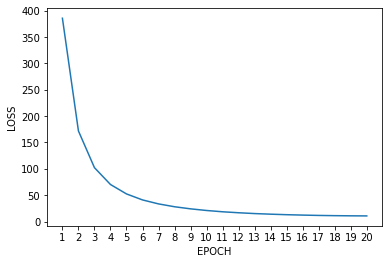

In [88]:
import math
print(losses)
x = np.arange(1, len(losses)+1)
y = losses
plt.xlabel('EPOCH')
plt.ylabel('LOSS')  
plt.xticks(x)
plt.plot(x, y)
plt.savefig('test/Seq2Seqtransloss{}.jpg'.format(epochs))
plt.show()

In [18]:
import numpy as np
import pandas as pd
import random
def get_test_result(dataloader):
    seq2seq.eval()
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    err_count = 0
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    loss = nn.CrossEntropyLoss()
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_target_ids, b_masks, _ = tuple(t.to(device) for t in batch)
        
        for b_input_id, b_target_id, b_mask in zip(b_input_ids, b_target_ids, b_masks):
            
            masked_index = torch.nonzero(b_label).cpu().numpy()[:,0]
            token = [int(i) for i in b_input_id.cpu().numpy() if i != 0] 
            sentence = tokenizer.decode(b_target_id[:len(token)]) #轉成中文句
            realList = sentence.split()
            corList = sentence.split()
                
            if len(masked_index) == 0 or '[UNK]' in realList or 'ｓａｍｇｅｔａｎｇ' in realList:continue
            
            # Compute logits
            with torch.no_grad():
                logits = seq2seq(torch.unsqueeze(b_input_id, 0), torch.unsqueeze(b_target_id, 0), torch.unsqueeze(b_mask, 0))   
            # Compute loss
            #losses = logits[0]
            m_logits = logits[1].cpu().numpy()
            mask_logits = torch.tensor([m_logits[0][i] for i in masked_index])
            real_ids = torch.tensor([b_target_id.cpu().numpy()[i] for i in masked_index])
            pred_ids = torch.max(mask_logits, 1)[1].data
        
            text = tokenizer.decode(pred_ids)
            text = text.split()
            count = 0
            print(''.join(realList))
            for i in masked_index:
                corList[i] = ' [' + text[count] + '] '
                realList[i] = ' [' + realList[i] + '] '
                count+=1
            data["真實標記"].append(''.join(realList))
            data["預測標記"].append(''.join(corList))
            cor_count += sum(real_ids == pred_ids)
            err_count += list(b_label.cpu().numpy()).count(1)
            '''
            ## print the result
            print(torch.max(mask_logits, 1)[1].data, real_ids)
            print(loss(mask_logits, real_ids), losses)
            #loss(mask_logits, real_ids)
            text = tokenizer.decode(b_input_id)
            tokens = tokenizer.tokenize(text)

            print("輸入 tokens ：", tokens[:])
            print('-' * 50)
            for mask_id in masked_index:
                probs, indices = torch.topk(torch.softmax(logits[1][0][mask_id], -1), 1)
                predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())
                for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
                    tokens[mask_id] = t
            print("{}".format(tokens[:]))
            '''
        # Get the predictions    
        #pred = torch.max(logits[1], 1)[1].data
        #print(loss, pred)
        #y_pred_s += list(pred.cpu().numpy())          
        #y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    df = pd.DataFrame(data)
    df.to_csv('test/RoBertaCorrTestSIGHAN14finetuned.csv')
    print(err_count)
    return cor_count, df

# Compute the average accuracy and loss over the validation set.

#y_real_s, y_pred_s = get_test_result(val_dataloader)
num, df = get_test_result(val_dataloader)
#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


NameError: name 'b_label' is not defined

In [139]:
sents, inps = [], []
with open("1209\\CLP14_CSC_TestInput.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()        
        if not line:break
        #if len(line) > 60:continue
        sents.append(line.split()[1])
        #print(sent)
        
cors = []        
with open("1209\\CLP14_CSC_TestTruth.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        #if '0' in line.split(', '):continue
        cors.append(line.split(', ')[1:])
print(len(cors), len(sents))

cor_sents = []
labels, n = [], -1
for sent, cor in zip(sents, cors):
    if '0' in cor or len(sent) > 60:continue
    label = [0 for i in range(110)]
    
    for i in range(0, len(cor), 2):
        label[int(cor[i])-1] = 1
        sent = list(sent)
        mask_inp = list(sent)
        mask_inp[int(cor[i])-1] = '[MASK]'
        inp = ''.join(mask_inp)
        sent[int(cor[i])-1] = cor[i + 1]
        cor_sent = ''.join(list(sent))
        
    cor_sents.append(cor_sent)   
    labels.append(label)
    inps.append(inp)

    
for inpt, cor in zip(inps, cor_sents):
    print(inpt, cor)
'''        
labels, n = [], -1
with open("1209\\test_answer_14.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()  
        
        #print(n)
        #print(line, len(sents[n]), len(line))
        if not line or n > len(sents):break 
        n += 1
        if not '1' in line:continue          
        if len(sents[n]) > 60:continue
        labels.append([int(i) for i in line]+[0 for _ in range(110-len(line))])
        
        tmp = list(sents[n])
        for i in range(len(tmp)):            
            if line[i] == '1':      
                tmp[i] = '[MASK]'
                e = ''.join(tmp)
        inp.append(e)
for cor, inpt in zip(cors, inp):
    print(inpt, cor) 
'''
'''                
for sent, cor in zip(sents, cors):
    if '0' in cor :continue
    for i in range(0, len(cor), 2):
        sent = list(sent)
        sent[int(cor[i])-1] = cor[i + 1]
        cor_sent = ''.join(list(sent))
    #print(cor_sent, cor)
    
for sent, cor, inpt in zip(sents, cors, inp):
    print(sent, inpt, cor)
'''

1062 1062
相對的、每位產齡婦女的生育嬰兒個數卻[MASK]續下滑。這表示全球出現適合年齡生育的婦女不想生育的現象。 相對的、每位產齡婦女的生育嬰兒個數卻持續下滑。這表示全球出現適合年齡生育的婦女不想生育的現象。
問[MASK]就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。 問題就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。
以前戰爭時代沒什麼醫[MASK]設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數量也更多。 以前戰爭時代沒什麼醫療設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數量也更多。
在[MASK]，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。 在此，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。
後來因為人民生得越多，人口大幅[MASK]增加，產生了不少社會問題 後來因為人民生得越多，人口大幅地增加，產生了不少社會問題
成人市場已經飽和，現在「少子化」商機才是引人注目。能讓企業們轉移注目，「少子化」可不是小問題[MASK]！ 成人市場已經飽和，現在「少子化」商機才是引人注目。能讓企業們轉移注目，「少子化」可不是小問題囉！
企業[MASK]突然發現現在的青少年很會花錢。他們去購物時下手闊綽而不會像成人愛討價還價。 企業們突然發現現在的青少年很會花錢。他們去購物時下手闊綽而不會像成人愛討價還價。
第三，現在青少年有著多元化學習的機會，出國旅行對他們來說也不成大問題了，所以[MASK]少年所領取的知識比父母上一代豐富極了！ 第三，現在青少年有著多元化學習的機會，出國旅行對他們來說也不成大問題了，所以青少年所領取的知識比父母上一代豐富極了！
人的意識方面上，為了減少急[MASK]的的生孩子率，需要呼籲適當的生育政策。 人的意識方面上，為了減少急變的的生孩子率，需要呼籲適當的生育政策。
而這樣的[MASK]況到底該稱之為「社會危機」，還是它能為全人類帶來什麼樣的好處嗎？ 而這樣的情況到底該稱之為「社會危機」，還是它能為全人類帶來什麼樣的好處嗎？
中國人自古至今有一個刻[MASK]觀念，認為生育男性才有未來，女孩嫁出去就是「潑出去的水」，沒有作用，更無法傳宗接代。 中國人自古至今有一個

"                \nfor sent, cor in zip(sents, cors):\n    if '0' in cor :continue\n    for i in range(0, len(cor), 2):\n        sent = list(sent)\n        sent[int(cor[i])-1] = cor[i + 1]\n        cor_sent = ''.join(list(sent))\n    #print(cor_sent, cor)\n    \nfor sent, cor, inpt in zip(sents, cors, inp):\n    print(sent, inpt, cor)\n"

In [88]:
labels, inp, cor = [], [], []
err_n = 0
with open("1209\\test_input_text_answer_15.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        e, c, l = line.split('-***-')
        cor.append(c)        
        labels.append([int(i) for i in l]+[0 for _ in range(110-len(l))])
        tmp = list(e)
        for i in range(len(tmp)):            
            if l[i] == '1':      
                err_n += 1
                tmp[i] = '[MASK]'
                e = ''.join(tmp)
        inp.append(e)
print(err_n)
#print(inp, cor, labels)
'''       
with open("1209\\testCorpus.txt",'r',encoding='utf-8') as test:
    while True:
        line = test.readline().strip()
        if not line:break
        texts.append(line)
        labels.append([0 for j in range(MAX_LEN)])
''' 


679


'       \nwith open("1209\\testCorpus.txt",\'r\',encoding=\'utf-8\') as test:\n    while True:\n        line = test.readline().strip()\n        if not line:break\n        texts.append(line)\n        labels.append([0 for j in range(MAX_LEN)])\n'

In [140]:
test_inputs, test_masks_i = preprocessing_for_bert(inps)
test_corrects, test_masks_c = preprocessing_for_bert(cor_sents)
test_labels = torch.tensor(labels)
print(test_labels.size(), test_corrects.size())

test_data = TensorDataset(test_inputs, test_labels, test_corrects, test_masks_i)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
num, df = get_test_result(test_dataloader)

#df.to_csv('test/Bert20WLSTMSIGHAN2014.csv'.format(epochs,mode))
df

C:\Users\islab\Anaconda3\envs\pytorch\lib\site-packages\transformers-4.1.1-py3.8.egg\transformers\tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


torch.Size([390, 110]) torch.Size([390, 110])
相對的、每位產齡婦女的生育嬰兒個數卻持續下滑。這表示全球出現適合年齡生育的婦女不想生育的現象。
問題就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。
以前戰爭時代沒什麼醫療設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數量也更多。
在此，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。
後來因為人民生得越多，人口大幅地增加，產生了不少社會問題
成人市場已經飽和，現在「少子化」商機才是引人注目。能讓企業們轉移注目，「少子化」可不是小問題囉！
企業們突然發現現在的青少年很會花錢。他們去購物時下手闊綽而不會像成人愛討價還價。
第三，現在青少年有著多元化學習的機會，出國旅行對他們來說也不成大問題了，所以青少年所領取的知識比父母上一代豐富極了！
人的意識方面上，為了減少急變的的生孩子率，需要呼籲適當的生育政策。
而這樣的情況到底該稱之為「社會危機」，還是它能為全人類帶來什麼樣的好處嗎？
中國人自古至今有一個刻版觀念，認為生育男性才有未來，女孩嫁出去就是「潑出去的水」，沒有作用，更無法傳宗接代。
在１９９０愛莎妮亞人口超過１５０萬人，但是現在我們的人口不到１３５萬人。
我們獨立之後的經濟情況很差，那時候我們還繼續使用俄羅斯的貨幣，必須面對通貨膨脹的問題。
人口越少，管理整個國家越複雜，哪裡都缺人才，甚至於我們政府得改移民法律，讓外籍人移民到愛沙尼亞。
「少子化」也有一些好處，比方說，我們就沒空間的問題了，房子、院子都越來越大，人民不會碰到因空間不夠而造成衝突這種問題。
追溯到早期的社會，直到現今，人類將隨著各方面的進步而不斷產生「少子化」的現象衍生。
有許多已開發國家將工廠移轉到人口較多的國家，給開發中國家提供就業的來源。
即使再多的人口，但如果懵懂無知的話不但對國家展毫無助益，甚至在一個極端派的煽動之下很容易成為反社會主義者。
「少子化」正面的影響可以說是比較少，但是最主要就是可以減少許多的經費及資源，也可改善環境的汙染。
而負面的影響最主要的就是人口數的減少會使人們的工作量增加、所要背負的負擔加重及人口老年化等的問題。
時代的改變，慢慢將人類的觀念換新以及改革，人們早已不像從前那樣，不懂得如何避孕，然後

希望在未來學習的期間我會好好地努力，不會讓老師失望。
開學已經過了兩個禮拜，幸運的是，我上到很好的老師的課。
希望老師您可以體諒我的煩惱而改變上課的方式，也許是我不夠聰明，但我還是希望在上老師課可以學到一些東西。
希望老師您可以幫我解決這個問題，這門課是我最難也最重要的課，我當然希望可以拿到最好的分數而讓父母感到驕傲。
他們實在對我太好了，我不想辜負了他們的愛心，希望以後可以好好地孝順他們老人家。
最近天氣冷了，您的身體舒服？真的似乎來秋天啊！
您的課聽得好，總是教得努力，我很感動。
您教台灣的情況、藝術、各地的消信、有意思的故事，我們都覺得您的課很有意思。
第一次上課的時候我很緊張，老師說的話完全聽不懂。我很生氣了對我自己，「為甚麼我一個人聽不懂啊」。
您記著嗎？我去找您以後，說「請幫助我」，那天以後，您每天幫助我。
從有一天越來越聽得懂您的課，我很感謝您的幫助。
學生王天華敬上。
把鮮蝦子炸以後加鳳梨罐頭再加沙拉醬的。我們孩子也很喜歡吃鳳梨蝦球，所以去溫泉時我們常常點鳳梨蝦球，味道真好。
父母很忙，有的時候吃快餐，我們平常吃很少菜，所以吃中國菜的時候會吃很多菜。
日本菜跟中國菜不一樣，日本菜比中國菜比較清淡的。
我剛來台灣的時候，吃含有蒜料理的話，我的胃部很痛，沒辦法常吃，但是已經習慣了，我最近做料理的時候常用蒜，薑。
我覺得中國食物的特色是顯出當材料本來的味道，反而韓國食物的特色是除了材料的味道以外顯出其他放東西的味道。
因為我覺得中國菜蠻油膩，還有聞得起來很特別的味道，沒有日本菜的那麼口味好。
最不好的菜是臭豆腐，最不喜歡的是聞，我一聞就想吐，味道也不太好。這個菜是外國人的口味不一樣的菜。
中國菜和韓國菜不一樣。中國菜是一點膩，可是韓國菜是大部分的菜一點辣。
我常常跟朋友一起逛夜市，我台灣人的朋友們個個很親切地每次介紹我不同的台灣小吃。
我覺得去夜市讓你們感到台灣的氣氛，還有台灣很有名美味的食物，可能你想吃的東西什麼都有！
差一點我忘記要請你幫我帶來一些東西。那些東西我可以請我家人給你。我家人已經知道了你要來台灣所以他們也風放心。
我們這樣認識了，可是她原來我們系的學姐。這麼巧！不過她因為剛轉中文系，而她也剛開始學中文。
房子裡布置的家具跟房間的安排也滿不錯，我還好滿足啦。
在日本也可能住很久的話，當然會來東西的壽命。可是好像台灣的壽命比日本短得多。
這個地

,真實標記,預測標記
0,相對的、每位產齡婦女的生育嬰兒個數卻 [持] 續下滑。這表示全球出現適合年齡生育的婦女不想生...,相對的、每位產齡婦女的生育嬰兒個數卻 [持] 續下滑。這表示全球出現適合年齡生育的婦女不想生...
1,問 [題] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。,問 [題] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。
2,以前戰爭時代沒什麼醫 [療] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...,以前戰爭時代沒什麼醫 [療] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...
3,在 [此] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。,在 [想] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。
4,後來因為人民生得越多，人口大幅 [地] 增加，產生了不少社會問題,後來因為人民生得越多，人口大幅 [度] 增加，產生了不少社會問題
...,...,...
375,你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯] [絡] ，拜拜。,你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯] [絡] ，拜拜。
376,我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...,我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...
377,那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [幸] 虧他們很愛...,那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [多] 虧他們很愛...
378,我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。,我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。


In [141]:
num

tensor(373)

In [163]:
import numpy as np
import pandas as pd
import random
maskedLM_model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)
maskedLM_model = maskedLM_model.to(device)
def get_test_result(dataloader):
    bert.eval()
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    loss = nn.CrossEntropyLoss()
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_target_ids, b_masks = tuple(t.to(device) for t in batch)
        
        for b_input_id, b_label, b_target_id, b_mask in zip(b_input_ids, b_labels, b_target_ids, b_masks):
            
            masked_index = torch.nonzero(b_label).cpu().numpy()[:,0]
            token = [int(i) for i in b_input_id.cpu().numpy() if i != 0] 
            sentence = tokenizer.decode(b_target_id[:len(token)]) #轉成中文句
            realList = sentence.split()
            corList = sentence.split()
                
            if len(masked_index) == 0 or '[UNK]' in realList or 'ｓａｍｇｅｔａｎｇ' in realList:continue
            
            # Compute logits
            with torch.no_grad():
                logits = maskedLM_model(input_ids = torch.unsqueeze(b_input_id, 0), attention_mask = torch.unsqueeze(b_mask, 0), labels=torch.unsqueeze(b_target_id, 0) )   
            # Compute loss
            #losses = logits[0]
            m_logits = logits[1].cpu().numpy()
            full = torch.max(torch.tensor(m_logits[0]), 1)[1].data
            print(tokenizer.decode(full))
            mask_logits = torch.tensor([m_logits[0][i] for i in masked_index])
            real_ids = torch.tensor([b_target_id.cpu().numpy()[i] for i in masked_index])
            pred_ids = torch.max(mask_logits, 1)[1].data
        
            text = tokenizer.decode(pred_ids)
            text = text.split()
            if len(text) != len(masked_index):continue
            count = -1
            #print(''.join(realList), masked_index, text)
            for i in masked_index:
                count+=1
                corList[i] = ' [' + text[count] + '] '
                realList[i] = ' [' + realList[i] + '] '
                
            data["真實標記"].append(''.join(realList))
            data["預測標記"].append(''.join(corList))
            cor_count += sum(real_ids == pred_ids)
            '''
            ## print the result
            print(torch.max(mask_logits, 1)[1].data, real_ids)
            print(loss(mask_logits, real_ids), losses)
            #loss(mask_logits, real_ids)
            text = tokenizer.decode(b_input_id)
            tokens = tokenizer.tokenize(text)

            print("輸入 tokens ：", tokens[:])
            print('-' * 50)
            for mask_id in masked_index:
                probs, indices = torch.topk(torch.softmax(logits[1][0][mask_id], -1), 1)
                predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())
                for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
                    tokens[mask_id] = t
            print("{}".format(tokens[:]))
            '''
        # Get the predictions    
        #pred = torch.max(logits[1], 1)[1].data
        #print(loss, pred)
        #y_pred_s += list(pred.cpu().numpy())          
        #y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    df = pd.DataFrame(data)
    df.to_csv('test/BertCorrTestSIGHAN14origin.csv')
    return cor_count, df

# Compute the average accuracy and loss over the validation set.

#y_real_s, y_pred_s = get_test_result(val_dataloader)
#num, df = get_test_result(val_dataloader)
#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [164]:
num, df = get_test_result(test_dataloader)
print(num)
df

相 對 的 、 每 位 產 齡 婦 女 的 生 育 嬰 兒 個 數 卻 繼 續 下 滑 。 這 表 示 全 球 出 現 適 合 年 齡 生 齡 的 婦 女 不 想 生 育 的 現 象 。 相 相 相 相 相 ： ： 的 的 的 育 兒 兒 的 卻 的 每 個 育 齡 的 的 的 的 育 嬰 兒 卻 繼 在 繼 續 繼 的 ， 示 是 示 ， 正 正 現 了 不 於 於 齡 的 的 ， ， 不 想 不 想 的 。 。 相 相 相 相 的
問 。 就 在 於 。 從 １９６０ 年 １９６０ 年 雖 然 產 齡 婦 女 率 低 。 但 平 均 每 位 產 齡 婦 女 生 育 的 嬰 兒 率 高 。 而 之 在 之 在 ， 問 少 的 的 。 。 。 到 １ １ 。 。 。 。 。 。 到 １０６０ 到 １ 。 １ 。 。 雖 然 產 的 婦 女 婦 。 。 。 。 而 。 而 育 齡 婦 所 生 的 的 的 高 率 。 。 在 在 問 問 問 問 問 問
新 前 戰 爭 時 代 沒 什 麼 醫 學 設 備 像 現 在 那 麼 普 及 ， 但 一 個 家 庭 生 孩 子 的 比 率 增 多 。 相 反 是 死 亡 的 數 量 也 更 多 ，...... 在 在... 新 麼 醫 學 ， 備 像 像 像 那 麼 ， ， 有 醫 麼 醫 學 像 備 像 像 是 那 麼 的 。 。 是 是 是 個 。 。 的 的 的 就 就 就 。 。 。 ， ， ， ， 的 的 就 就 就 少...... 在 在 在
， 而 ， 我 想 最 重 要 的 還 是 能 於 培 育 出 一 群 傑 出 的 資 源 。 能 於 為 國 家 榮 榮 、 願 意 貢 獻 一 個 力 量 的 人 才 。 總 總 而 而 ， ， 最 ， ，... ， ， ， 要 ！ ！ ！ 。 。 。 最 最 是 。 。 能 能 能 能 能 有 有 有 有 有 。 。 。 能 能 夠 能 夠 為 而 能 能 能 夠 所 多 多 多 的 的 的 的 的...... 當... ， ， ， 最
代 來 因 為 人 民 生 得 越 多 ， 人 口 大 幅 的 增 加 ， 產 生 了 一 多 社 會 問 題 ， ， ， ， ， ， ， 一 的 一 的 社 的 的 ， ， ， ， ， ， 代 世 的 的 的 的 的 ， ， 也 的 的 

》 家 家 家 就 近 中 山 捷 運 站 附 近 ， 所 以 我 們 就 約 在 捷 運 站 五 號 出 口 好 了 。 約 《 《 ， ， ， 》 》 ５ 近 好 。 《 ， ， ， ， ， ， ， ， 的 站 附 附 附 近 ， ， ， ， 就 就 近 離 運 捷 附 附 附 就 。 好 約 約 約 約 約 約 約 約 101 五 附 好 。 好 《 《 《 ， ， ， ， ， 約 約 五 號 出 。 ： 《 年 ， 年 ， ， ，
[UNK] 說 我 們 離 士 林 很 近 ， 我 想 我 們 吃 完 飯 以 後 再 去 那 裡 逛 一 逛 。 因 為 那 裡 的 小 吃 不 但 非 常 多 ， 又 好 真 ， 而 而 ， 不 不 不 不 不 。 。 。 但 但 不 在 不 在 不 不 不 不 不 ， ， ， 我 是 會 想 會 之 會 會 會 會 會 會 去 去 去 ， 。 這 這 那 那 那 ， ， ， ， 有 美 ， ， 又 是 又 ， 那 那 ， ， 不 在 不
是 覺 得 我 們 那 一 天 都 穿 著 紅 色 的 衣 服 ， 跟 白 色 的 褲 子 。 好 了 頭 上 有 一 頂 藍 色 的 帽 子 。 這 樣 我 們 一 定 不 會 認 錯 人 了............... 們 就 是 的 。 。 。 。 在 在 這 在 是 是 是 著 著 跟 的 的 跟 跟 跟 的 的 的 的 ， 。 。 在 在 有 有 有 有 頂 的 帽 ！ 。 。 我 就 我 就 就 就 就 是 是 錯 人 吧... 這
生 果 我 家 的 狗 還 沒 把 我 的 天 藍 色 襯 衫 咬 破 的 話 ， 我 會 穿 著 白 色 的 褲 子 在 誠 品 外 等 你 抵 達 。...... 2 在 生......... 的 。 的 你 。...... 你 狗 狗 灰 狗 狗 狗 狗 狗 狗 狗 還 還 ， 穿 的 穿 藍 狗 狗 話 ， 話 ， 。... 穿 穿 穿 穿 穿 著 穿 ， ， 著 誠 的 外 等 你 你 。...... 穿 我......... 著 誠 誠 外 等 你
因 為 您 還 沒 有 看 過 １０１ ， 我 會 先 幫 我 們 買 去 樓 頂 的 票 ， 看 看 風 景 。 看 因 因 因 等 要 要 ， ， ， ， ， 看 ， 因 因 因 等 因

。 們 可 以 下 禮 拜 六 早 上 九 點 在 大 安 森 林 公 園 見 面 ， 好 不 好 ？ 我 打 算 我 們 先 在 公 園 靜 靜 地 散 步 一 下 。 然 後 去 旁 邊 的 咖 啡 館 喝 喝 啡 。 聊 天 。 我 我 我 ， 在 ， ， ， ， ， 九 ， 在 在 在 的 的 的 再 ， ， ， ， ？ 好 ？ ？ ？ 。 。 。 先 先 先 先 中 的 的 步 步 。 。 。 再 在 在 在 在 的 的 的
你 了 讓 你 認 得 我 ， 我 會 穿 我 黑 皮 夾 克 ， 戴 藍 色 的 帽 子 。 我 也 會 帶 我 的 小 狗 去 ， 你 大 概 知 道 是 哪 一 個 。 牠 的 眼 睛 藍 藍 的 ， 圓 圓 的 。 我 我 我 我 我 ， ， 我 黑 鞋 我 我 我 著 我 的 的 ， ， ， 戴 我 我 的 的 ， ， 我 我 會 會 我 我 狗 ， ， 。 不 不 不 不 是 圓 的 隻 隻 。 牠 的 ， ， ， 色 的
， 知 道 一 個 又 好 笑 又 怪 怪 的 地 方 ， 可 以 介 紹 你 。 那 家 看 起 來 很 好 看 ， 我 怕 看 得 讓 你 覺 得 不 舒 服 。 但 是 很 好 玩 ， 他 們 的 菜 還 不 錯 ， 請 嚐 嚐 ， 不 是 是 是 是 是 是 是 ， ， 很 很 我 我 來 來 說 ， 說 是 ， ， ， ， 看 很 很 很 ， 怕 怕 怕 會 會 會 會 很 很 。 。 不 不 是 不 不 但 ， 家 的 的
明 天 我 會 穿 綠 帽 子 ， 穿 粉 紅 色 襯 衫 ， 手 上 拿 「 王 宜 家 」 旗 子 ， 你 應 該 不 會 有 問 題 認 出 我 。 嘿 明 明 明 明 明 明 明 穿 穿 穿 明 明 嘿 明 明 黑 黑 黑 ， 明 穿 穿 穿 穿 穿 黑 明 的 的 的 。 ， 。 ， 在 手 會 戴 「 王 明 王 的 。 但 但 你 就 會 會 會 有 有 會 的 明 我 嘿 嘿 嘿 明 明 明 明 明 明 明 明 穿 明
line 是 李 希 平 。 知 道 我 們 在 兩 個 禮 拜 就 要 見 面 。 我 真 很 高 興 。 期 。 因 為 我 們 在 網 路 聊 天 了 快 一 年 了 。 我 是 是 是 是 是 是 ， 。 。 。 在 在 在 約 就

国 但 人 很 好 ， 他 們 還 喜 歡 幫 助 人 。 迷 路 的 人 ， 或 是 你 需 要 幫 忙 ， 他 們 他 們 馬 上 來 幫 你 的 忙 。 韓 韓 韓 韓 韓 韓 ， 會 會 會 幫 忙 你 不 不 人 人 人 有 有 有 人 人 人 人 人 ， 是 是 是 人 是 在 是 迷 人 人 人 人 ， 是 你 忙 忙 路 有 在 有 在 會 會 會 會 來 幫 你 忙 忙 你 不 韓 韓 韓 韓 ， 會 會 會 會 來
雖 然 對 我 來 說 ， 我 的 英 文 還 不 算 ， 但 是 波 士 頓 人 的 口 音 很 難 聽 ， 我 有 很 多 的 問 題 他 們 的 口 音 。 我 有 我 有 有 ， 然 然 ，... 的... 的 算 算 算 。 。 雖 然 然 。 ，... ， 算 的 算 算 算 算 好 是 們 是 是 人 人 人 的 的 的 很 很 是 有 有 有 有 有 的 問 ， ， 的 的 的 的 是 我 有 我 有 有 有 的 ， ， ，
我 的 朋 友 跟 我 說 別 擔 心 ， 慢 慢 你 會 聽 得 懂 波 士 說 的 語 音 。 一 個 禮 拜 以 後 我 甚 麼 問 題 都 沒 有 了 但 波 士 說 的 語 音 我 都 聽 得 懂 說 嗯 我 我 是 我 我 我 我 ， 懂 講 我 說 我 ， ， ， 慢 我 你 會 聽 聽 懂 說 說 的 的 的 的 在 一 個 禮 拜 以 ， ， 說 的 的 也 也 懂 說 但 說 說 說 的 的 我 我 我 都 聽 得
的 在 法 國 已 經 一 個 禮 拜 多 了 ， 時 間 真 過 著 很 快 ． ． 。 。 這 一 次 來 法 文 遇 到 很 多 很 有 意 思 的 事 ， 我 想 聽 妳 說 說 如 如 是 是 是 ， ， 我 我 想 間 間 間 也 也 有 有 快 一 月 多 了 但 但 間 間 間 真 過 得 慢 慢 。 。 。 。 。 。 。 。 。 。 遇 。 。 。 很 很 。 事 。 ， 我 我 想 想 你 。 。 。 如 是 是
妳 給 我 的 台 灣 烏 龍 茶 ， 我 爸 爸 給 我 的 高 台 酒 ， 我 自 己 買 的 原 住 民 音 樂 ， 我 都 給 他 了 ， 他 非 常 高 興 。 我 就 跟 妳 說 ， 禮 多 人 不 怪 ， 我 我 我 妳

最 近 我 的 生 活 變 得 很 苦 悶 ， 我 天 天 睡 不 著 而 食 物 也 吃 不 下 。 都 是 那 位 美 女 在 你 的 生 日 會 的 錯 ！ 最 最 最 最 最 最 最 最 ，... 上 ！ ！ ， 最 最 最 最 最... 最 ， 的 也 吃 吃 吃 不 下 。 我 天 天 睡 ， ， ， 我 嚥 吃 吃 ！ ！ ！ ， ， ，... ， ， 在 你 的 的 的 上 的... ， 最 最 最 最 最 最 ，...... 的
是 就 是 我 下 過 雨 的 天 夏 天 。 有 她 就 讓 我 覺 得 很 期 待 。 那 時 候 我 就 決 定 了 。 她 不 是 從 外 世 界 來 的 。 就 是 對 我 來 說 她 一 定 是 天 使 。 但 但 沒 有 有 ， ， ， 說 說 天 。 天 。 。 但 有 她 ， ， 她 我 我 我 很 很 。 。 。 候 候 我 就 。 了 。 也 不 外 外 外 外 外 。 。 也 就 是 她 她 她 說 她 一 不
。 個 禮 拜 六 ， 在 你 最 喜 歡 的 夜 店 ， 我 愛 上 了 最 漂 亮 的 女 生 。 我 還 不 知 道 她 的 名 字 呢 。 可 是 我 已 經 確 定 我 想 當 上 的 白 馬 公 主 。 我 我 我 我 我 我 你 你 你 你 你 你 你 最 的 的 在 。 。 。 我 了 你 了 最 最 的 的 的 。 我 我 我 是 我 你 你 的 是 是 。 馬 。 。 。 我 我 我 你 我 你 上 上 你 你 。
她 的 臉 白 白 的 ， 圓 圓 的 ， 頭 髮 黑 黑 的 ， 眼 睛 大 大 的 。 所 穿 的 衣 服 也 很 適 合 她 ， 看 起 來 就 算 是 一 個 女 神 不 說 ， 她 的 性 格 也 算 是 非 常 溫 柔 ， 她 她 她 在 她 也 也 是 她 所 所 所 她 黑 的 她 小 小 睛 大 大 她 所 所 所 所 的 的 也 都 不 合 她 她 穿 她 就 也 就 是 一 。 。 。 。 而 ， 她 的 也 也
要 時 候 我 就 睡 醒 了 ， 我 覺 得 很 害 怕 ， 不 能 再 睡 覺 。 ， 要 要 要 要 要 要 該 要 要 要 在 在 ， 要 該 該 要 要 要 要 該 該 該 要 要 要 在 ， 該 該 要 要 在 在 

希 望 老 師 您 可 以 原 諒 我 的 煩 惱 而 改 變 上 課 的 方 式 。 也 許 是 我 不 夠 聰 明 。 但 我 還 是 希 望 在 上 老 師 您 可 以 學 到 一 些 東 西 。 希 希 希 望 您 您 ， 而 您 您 您 您 您 ， 能 您 。 我 ， 而 而 而 我 您 我 的 的 。 。 。 。 。 是 我 我 我 您 夠 是 您 您 。 。 。 望 在 上 您 您 您 您 您 以 多 些 些 的 。 希
希 望 希 師 您 可 以 幫 我 解 決 這 個 問 題 ， 這 門 課 是 我 最 難 。 最 重 要 的 課 。 我 當 然 希 望 可 以 拿 到 最 好 的 分 數 。 讓 父 母 感 到 驕 傲 的 希 希 希 希 希 希 希 望 希 。 也 。 望 能 我 。 是 的 的 的 課 是 課 也 課 是 我 是 是 、 、 也 最 的 課 。 。 也 然 也 望 到 。 到 。 。 。 。 。 。 。 讓 為 到 感 到 到
級 們 實 在 對 我 太 好 了 ， 我 不 想 辜 負 了 他 們 的 愛 心 我 希 望 以 後 可 以 好 好 的 孝 順 他 們 老 人 家 的 二 中 二 級 的 級 的 級 的 的 的 的 的 ， 我 我 我 也 再 再 也 是 是 是 太 太 太 ， 我 我 我 再 再 辜 辜 我 的 的 的 的 的 老 ， 我 我 我 我 ， 的 的 的 的 愛 我 們 的 老 的 的 我 中 中 級 的 的 的 ， ， 我 的 的
最 近 天 氣 冷 了 ， 您 的 身 體 舒 服 ？ 真 的 似 乎 來 秋 天 了 ！ 真 真 真 最 真 最 最 最 是 來 了 了 了 真 真 真 最 最 最 最 最 全 最 全 來 了 了 了 真 真 有 又 體 ？ ？ ， 最 近... 來 來 了 了 了 真 真 最 最 最 最 最 最 來 是 來 了 了 了 真 真 最 最 全 最 最 全 是 是 來 來 來 了 了 啊 真 全 最 全 最 全 全 最 全 ， 氣 冷 了
中 的 課 聽 得 好 ， 總 是 教 得 努 力 ， 我 很 感 動 。 ( 中 中 中 中 是 是 ， ， 中 中 中 中 中 中 中 中 中 中 是 得 微 斯 ， 中 中 中 中 中 中 中 中 中 中 。 很 得 斯 ， 。 中

那 下 個 月 我 等 你 們 來 。 我 也 不 得 過 日 子 因 為 我 真 想 你 們 了 。 我 我 它 它 年 美 它 美 美 我 我 我 。 我 我 我 也 它 那 那 美 它 美 它 歌 我 大 它 也 也 也 也 不 它 我 我 我 我 大 大 我 我 。 我 也 也 也 它 它 它 它 它 它 真 我 我 我 我 也 不 也 不 那 那 那 那 那 它 它 我 我 我 我 它 它 它 那 那 那 那 它 美 我 等
老 來 台 灣 沒 有 去 上 中 文 課 ， 她 拿 書 回 家 自 己 學 ， 很 用 功 的 學 ， 三 四 年 後 ， 她 的 文 強 ， 現 在 她 不 是 。 會 講 而 看 報 紙 像 臺 灣 人 的 速 度 。 她 她 她 看 看 看 她 她 看 她 認 的 的 她 就 要 她 ， 她 自 自 ， 她 很 的 的 的 的 的 而 ， ， ， ， 她 的 文 ， 。 。 。 。 。 她 。 看 看 看 看 看 看 看 老
有 覺 得 中 文 可 以 跟 台 灣 人 溝 通 ， 她 開 始 做 生 意 。 她 在 桃 園 開 一 家 越 南 店 ， 賣 越 南 菜 ， 生 意 很 好 但 客 人 大 部 分 是 越 南 外 勞 。 她 她 她 後 她 ， 就 就 她 做 她 ， 她 跟 跟 的 她 ， 她 ， 就 就 她 做 做 了 。 ， 在 在 園 開 ， 了 。 。 賣 她 賣 賣 的 。 。 她 但 她 但 但 的 的 大 都 都 是 是 籍 外
為 什 麼 他 是 我 最 難 忘 的 人 ？ 因 為 他 是 我 的 初 戀 。 他 去 美 國 以 後 ， 一 次 也 沒 看 到 他 。 可 是 我 依 是 很 想 他 。 這 這 這 是 是 他 他 我 我 他 他 他 他 他 他 他 他 他 他 我 最 他 他 他 他 他 他 他 他 他 他 的 的 ， 他 他 他 他 了 以 ， ， 我 我 也 沒 看 過 他 但 ， ， 我 我 是 很 愛 他 他 這 這 這 這 是 這
是 約 兩 年 前 ， 我 跟 朋 友 去 綠 島 旅 行 時 ， 遇 到 了 綠 島 的 空 軍 軍 人 ， 他 們 就 是 最 難 忘 的 人 。... 是 是 是 是 是 是 是 是 很 是...... 是 在 在 在 去 。 ， ，

國 了 訂 婚 禮 郎 外 外 休 假 過 得 好 嗎 ？ 我 希 望 你 找 到 了 打 工 的 機 會 ， 讓 你 有 賺 錢 的 方 法 。 外 我 我 我 我 我 你 你 除 式 禮 堂 海 外 外 外 還 還 還 還 外 外 除 郎 子 郎 海 海 外 的 休 假 真 還 外 外 外 我 你 外 你 另 有 了 有 了 的 ， ， ， 我 你 有 有 有 的 的 ， 在 我 我 的 外 ， ， 外 你 有 有 有 的 俗 海
校 園 會 有 十 幾 位 有 名 的 拉 麵 廚 師 擺 地 攤 賣 拉 麵 ， 各 種 各 樣 的 肉 、 菜 、 菜 菜 等 等 。 有 有 有 有 的 的 肉 ， 中 中 ， ， ， ， 有 有 。 有 名 的 。 。 。 。 。 。 。 。 。 。 。 有 的 的 拉 的 。 。 攤 賣 攤 賣 ， ， ， 有 有 各 樣 的 肉 ， 肉 ， ， ， ， 等 ， 有 有 有 各 樣 的 肉 ， 肉 ， ， ， ， 中 ， 多
你 應 該 知 道 楊 丞 琳 是 我 的 大 學 研 究 所 畢 業 。 她 不 會 是 一 個 很 漂 亮 的 明 星 歌 手 。 她 也 非 常 的 努 力 又 聰 明 。 在 在 在 是 是 是 是 是 。 。 的 的 的 的 。 。 。 。 。 ， ， ， 是 我 的 的 的 的 的 的 。 。 。 。 也 也 是 是 是 很 很 。 。 。 。 。 。 是 是 是 的 的 的 的 。 又 又 又 在 在 在 在 是 是 是
國 不 知 道 她 喜 不 喜 歡 拉 面 。 可 是 我 一 想 到 楊 丞 琳 吃 拉 麵 就 很 興 奮 了 。 簡 素 國 素 素 素 素 素 素 。 ： 。 。 簡 素 素 素 國 素 素 素 素 她 愛 的 。 。 。 我 素 素 我 們 們 琳 不 愛 愛 ， ， 會 就 。 。 ： 簡 素 琳 琳 琳 琳 琳 素 ， 是 ， 。 。 簡 簡 素 素 國 琳 琳 琳 她 ， ， 很 很 。 。 素 簡 素 國 素 她 們
4 些 活 動 一 定 會 讓 你 有 意 思 。 你 來 參 加 這 些 活 動 ， 很 開 心 得 不 得 了 。 2 4 4 4 4 4 是 很 很 得 得 得 好 2 2 4 4 的 是 是 ， 好 很 很 有 很 ， 你 你 來 

們 很 喜 歡 這 本 書 ， 因 為 ， 那 個 人 很 聰 明 的 人 ， 而 且 那 個 時 候 有 他 才 有 公 平 。 所 以 ， 我 真 的 很 喜 歡 。 。 。 。 。 ， 的 ， ， ， ， 很 ， ， ， ， 是 ， ， 的 的 的 ， 是 是 ， 是 ， 是 是 是 是 是 是 ， 而 且 且 且 且 且 ， ， 有 ， ， ， 的 ， ， ， ， ， ， ， 的 很 的 歡 ， 。 。 。 。 。 。 。 ，
美 國 進 入 第 二 世 界 戰 爭 的 時 候 ， 蔣 介 石 問 美 國 幫 打 仗 日 本 ， 他 需 要 美 國 的 軍 糧 ， 要 把 國 空 軍 現 代 化 ， 要 要 在 在 把 美 家 防 家 防 的 的 ， ， ， 進 ， 進 在 第 在 在 界 仗 的 的 ， ， ， 蔣 ， 軍 ， 軍 軍 幫 打 仗 的 防 打 軍 軍 要 軍 的 的 的 ， 要 要 空 軍 空 空 空 軍 化 ， 要 要 要 要 要 要 軍
， 介 石 當 史 迪 威 國 民 軍 委 員 副 總 統 ， 說 史 迪 威 可 以 領 導 中 國 的 軍 團 。 說 說 說 威 威 威 威 威 的 講 ， ， ， ， ， ， ， ， 的 威 的 威 的 民 會 的 的 的 ， ， ， ， 的 威 威 威 代 民 軍 會 的 的 說 說 說 說 威 威 威 威 威 領 以 中 在 的 ， 說 ， 說 ， 講 威 威 威 威 領 導 中 國 的 ， 說 ， ， ， ， ， 史 的
的 介 紹 幾 米 的 「 星 空 」 。 幾 米 是 台 灣 人 的 繪 本 作 家 ， 我 來 台 灣 以 後 看 他 的 展 覽 ， 那 時 候 我 才 知 道 他 。 他 畫 的 畫 真 的 漂 亮 。 我 很 感 動 。 我 我 我 我 的 的 的 。 。 ， ， ， ， 是 是 他 ， 他 的 繪 畫 畫 ， ， ， 是 是 爸 以 是 看 看 的 的 看 ， 候 候 候 我 才 。 。 他 他 他 他 的 畫 真 的 。
們 們 我 喜 歡 這 本 書 因 為 它 很 有 意 思 ， 不 太 難 ， 孩 子 看 得 懂 。 這 本 書 還 有 很 多 教 事 ： 忠 、 孝 、 孝 、 仁 。 孝 大 ， 們 們 們 們 愛 ， 孝 孝 孝 很 它 ， ， 

,真實標記,預測標記
0,相對的、每位產齡婦女的生育嬰兒個數卻 [持] 續下滑。這表示全球出現適合年齡生育的婦女不想生...,相對的、每位產齡婦女的生育嬰兒個數卻 [繼] 續下滑。這表示全球出現適合年齡生育的婦女不想生...
1,問 [題] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。,問 [。] 就在於，從１９５０－１９６０年雖然產齡婦女率低，但平均每位產齡婦女生育的嬰兒率高。
2,以前戰爭時代沒什麼醫 [療] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...,以前戰爭時代沒什麼醫 [學] 設備像現在那麼普遍，但一口家庭生孩子的比率增多，相反地死亡的數...
3,在 [此] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。,在 [而] ，我想最重要的還是能於培養出一群傑出的資源，能於為國家爭榮、願意貢獻一份力量的人才。
4,後來因為人民生得越多，人口大幅 [地] 增加，產生了不少社會問題,後來因為人民生得越多，人口大幅 [的] 增加，產生了不少社會問題
...,...,...
374,你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯] [絡] ，拜拜。,你要是錯過這麼好房間，沒有更好的房間喔！你應該早點決定吧！給我 [聯] [絡] ，拜拜。
375,我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...,我覺得那個房間非常好，因為房間很大，很乾淨， [再] 加上電費和水費都免費。房間裡面有一個床...
376,那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [幸] 虧他們很愛...,那一天是我最快樂的一天，因為我跟家人、朋友們、男朋友都一起慶祝我的生日， [不] 虧他們很愛...
377,我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。,我媽媽平常都忙著工作，連照顧自 [己] 也沒時間。這次我感覺到很溫暖的母子情。我更多愛她，很愛她。


In [15]:
import numpy as np
import pandas as pd
import random
mode = "sentence1times_eWord"

def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_masks = tuple(t.to(device) for t in batch)    

        # Compute logits
        with torch.no_grad():
            logits = bert_classifier(input_ids = b_input_ids, labels = b_labels, attention_mask=b_masks)    
        # Compute loss
        loss = logits[0]

        # Get the predictions    
        pred = torch.max(logits[1], 1)[1].data
        y_pred_s += list(pred.cpu().numpy())          
        y_real_s += list(b_labels.cpu().numpy())

        #sentence = tokenizer.decode(b_input_ids)
    #df = pd.DataFrame(data)
    return  y_real_s, y_pred_s

# Compute the average accuracy and loss over the validation set.

y_real_s, y_pred_s = get_test_result(val_dataloader)

#df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
#df


ValueError: too many values to unpack (expected 3)

In [ ]:
def get_test_result(dataloader):
    y_real_s = []
    y_pred_s = []
    cor_count = 0
    
    data = {
    "真實標記":[],
    "預測標記":[]
    }
    
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_labels, b_mask = tuple(t.to(device) for t in batch)    

        # Compute logits
        with torch.no_grad():
            logits = bert_classifier(input_ids = b_input_ids, labels = b_labels)    
        # Compute loss
        loss = logits[0]

        # Get the predictions    

        for logit, real, b_input_id in zip(logits[1], b_labels, b_input_ids):
            token = [int(i) for i in b_input_id.cpu().numpy() if i != 0] 
            pred = torch.max(logit, 1)[1].data
            sentence = tokenizer.decode(b_input_id[:len(token)]) #轉成中文句
            realList = sentence.split()
            predList = sentence.split()
            predLabel = torch.nonzero(pred)
            realLabel = torch.nonzero(real)

            if realLabel.size()[0] != 0:
                if realLabel[0].cpu().numpy() >= len(realList):continue
                if realLabel[-1].cpu().numpy() >= len(realList):continue

            if predLabel.size()[0] != 0:
                if predLabel[0].cpu().numpy() >= len(predList):continue
                if predLabel[-1].cpu().numpy() >= len(predList):continue  

            if predLabel.size()[0] == 1:            
                predList[predLabel[0]] = '['+predList[predLabel[0]]+']'
            elif predLabel.size()[0] > 1:
                for i in predLabel:
                    predList[i[0]] = '['+predList[i[0]]+']'
            data["預測標記"].append(''.join(predList)) 

            if realLabel.size()[0] == 1:            
                realList[realLabel[0][0]] = '['+realList[realLabel[0][0]]+']'
            elif realLabel.size()[0] > 1:
                for i in realLabel:
                    realList[i[0]] = '['+realList[i[0]]+']'
            data["真實標記"].append(''.join(realList))

            corr = torch.zeros((1,max_len)).type(torch.int64)
            corr = corr.to(device)

            if torch.equal(real, corr[0]):y_real_s += [1]
            else:y_real_s += [0]

            if torch.equal(pred, corr[0]):y_pred_s += [1] 
            elif torch.equal(pred, real):
                y_pred_s += [0]
                cor_count += 1
            else:
                y_pred_s += [0]

        #sentence = tokenizer.decode(b_input_ids)
    df = pd.DataFrame(data)
    return cor_count, df, y_real_s, y_pred_s

# Compute the average accuracy and loss over the validation set.

cor_count, df, y_real_s, y_pred_s = get_test_result(val_dataloader)
print(cor_count)
df.to_csv('test/Bert{}EpochErr_{}.csv'.format(epochs,mode))
df


IndexError: index 1 is out of bounds for axis 1 with size 1

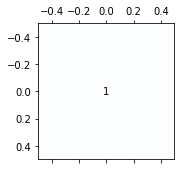

In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def show_confusion(y_real_s, y_pred_s):
    confmat = confusion_matrix(y_true=y_real_s, y_pred=y_pred_s)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')

    cm = {'tp': confmat[0, 0], 'fn': confmat[0, 1], 'fp': confmat[1, 0], 'tn': confmat[1, 1]}
    print(cm)
    total = sum(cm.values())
    print("accuracy:", (cm['tp']+cm['tn'])/total)

    recall = (cm['tp'])/(cm['tp']+cm['fn'])
    print("recall:", recall)

    precision = (cm['tp'])/(cm['tp']+cm['fp'])
    print("precision:", precision)

    print("f1-score:", 2/((1/precision)+(1/recall)))
    plt.xlabel('Prediction')        
    plt.ylabel('Real Label')
    plt.show()
    
show_confusion(y_real_s, y_pred_s)

In [ ]:
2/((1/0.972)+(1/1))

In [172]:
labels, texts = [], []
with open("1209\\中央社已處理\\test_answer.txt",'r',encoding='utf-8') as label:
    while True:
        line = label.readline().strip()
        if not line:break
        labels.append(1 if '1' in line else 0)
        #labels.append([int(i) for i in line]+[0 for j in range(MAX_LEN - len(line))])
    
with open("1209\\中央社已處理\\test_input.txt",'r',encoding='utf-8') as text:    
    while True:
        line = text.readline().strip()
        if not line:break
        texts.append(line)
'''       
with open("1209\\testCorpus.txt",'r',encoding='utf-8') as test:
    while True:
        line = test.readline().strip()
        if not line:break
        texts.append(line)
        labels.append([0 for j in range(MAX_LEN)])
''' 
        
test_inputs, test_masks = preprocessing_for_bert(texts)
test_labels = torch.tensor(labels)
print(test_labels.size(), test_inputs.size())

test_data = TensorDataset(test_inputs, test_labels, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
get_test_result(test_dataloader)

#df.to_csv('test/Bert20WLSTMSIGHAN2014.csv'.format(epochs,mode))
#df

NameError: name 'preprocessing_for_bert_At' is not defined

In [33]:
'''
bert_classifier, optimizer, scheduler = initialize_model(epochs)
checkpoint = torch.load('ckpt/bert_weight_10.h5')
bert_classifier.load_state_dict(checkpoint)
bert_classifier.eval()
'''

cor_count, df, y_real_s, y_pred_s = get_test_result(test_dataloader)
show_confusion(y_real_s, y_pred_s)
print(cor_count)
df.to_csv('test/Bert{}EpochErr_{}_SIGHAN_40w_16.csv'.format(epochs,mode))
df

ValueError: not enough values to unpack (expected 3, got 2)